In [5]:
import quadrature
import GPy

In [19]:
import scipy.stats
import numpy as np
def f_temp(x):
    return [scipy.stats.norm(3, 1).pdf(x[0])]
def f(x):
    return [scipy.stats.norm(3, 1).pdf(x[0]),scipy.stats.norm(0, 1).pdf(x[1])]
def flambda(a):
    modifier = np.sin(a)
    def f(x):
        return [(scipy.stats.norm(2.5, 1).pdf(a)*0.8 + scipy.stats.norm(-2.5, 1).pdf(a)*0.2) * modifier]
    return f

In [20]:
X = np.random.uniform(-10,10,size=(5,1))
Y = X.copy()
Y = np.apply_along_axis(flambda(0), 1, Y)
gp = GPy.models.GPRegression(X,Y,GPy.kern.src.rbf.RBF(input_dim=1))

In [21]:
A = {}
actions = np.linspace(-10,10,50)
Xs = {}
Ys = {}
gps = {}
for i,a in enumerate(actions):
    X = np.random.uniform(-10,10,size=(10,1))
    Y = X.copy()
    Y = np.apply_along_axis(flambda(a), 1, Y)
    Xs[a] = X
    Ys[a] = Y
    gps[a] = GPy.models.GPRegression(X,Y,GPy.kern.src.rbf.RBF(input_dim=1))
    arg = quadrature.compute_prereq(gps[a])
    A[a] = quadrature.integrate(gps[a],np.array([0.0]),10.0,*arg)

In [22]:
def extend(rand=False):
    maxa = max(A, key=lambda a:A[a][0]+3*A[a][1])
    if rand:
        maxa = np.random.choice(A.keys())
    print maxa
    X = Xs[maxa]
    X2 = np.random.uniform(-10,10,size=(3,1))
    print X.shape, X2.shape
    Xs[maxa] = np.vstack((X,X2))
    print Xs[maxa].shape
    Y = Xs[maxa].copy()
    Ys[maxa] = np.apply_along_axis(flambda(maxa), 1, Y)
    print Xs[maxa].shape, Ys[maxa].shape
    gps[maxa] = GPy.models.GPRegression(Xs[maxa],Ys[maxa],GPy.kern.src.rbf.RBF(input_dim=1))
    A[maxa] = quadrature.integrate(gps[maxa],np.array([0.0]),10.0,*quadrature.compute_prereq(gps[maxa]))

-2.244897959183673
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
7.142857142857142
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
7.142857142857142
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
7.142857142857142
(16, 1) (3, 1)
(19, 1)
(19, 1) (19, 1)
2.2448979591836746
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
7.142857142857142
(19, 1) (3, 1)
(22, 1)
(22, 1) (22, 1)
2.6530612244897966
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
1.4285714285714288
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
2.2448979591836746
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
7.95918367346939
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
8.367346938775512
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-10.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
2.2448979591836746
(16, 1) (3, 1)
(19, 1)
(19, 1) (19, 1)
3.8775510204081627
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
8.367346938775512
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-1.020408163265305
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
0.204081632653061
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
1.8367346938775508
(10, 1) (3, 1)
(1

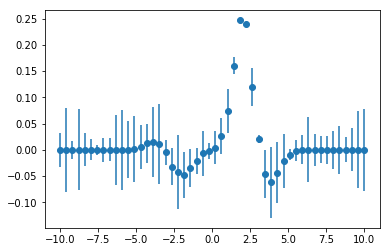

In [23]:
for i in range(60):
    extend(i%5==0)

x,y,e = [],[],[]
for a in A:
    x.append(a)
    y.append(A[a][0])
    e.append(A[a][1])
    import matplotlib.pyplot as plt
    plt.clf()
    plt.errorbar(x, y, yerr=e, fmt='o')
    plt.savefig("./imgs/%03d.png" % i)

In [1]:
import quadrature
import numpy as np
import scipy

In [2]:
def flambda(a):
    modifier = np.sin(a)
    def f(x):
        return [(scipy.stats.norm(2.5, 1).pdf(a)*0.8 + scipy.stats.norm(-2.5, 1).pdf(a)*0.2) * modifier]
    return f
O = quadrature.OPT_Rand1D(flambda,-10,10,40,-5,5,np.array([0.0]),1.0,70)

10.0 (-1.4461986403799408e-16, 0.5773484058632268)
10.0 (-4.3280538454325225e-14, 0.15098903084698778)
10.0 (-5.695663244571877e-14, 0.1208858640354292)
10.0 (-7.656388082900939e-14, 0.0630840275958909)
10.0 (-8.603951376488237e-14, 0.04621593742316346)
10.0 (-8.810722985833762e-14, 0.039258111889199504)
10.0 (-9.392284308605699e-14, 0.020535232909631135)
10.0 (-9.661683391583715e-14, 0.013795045939237555)
10.0 (-1.0104078627365998e-13, 0.0011213716890413339)
10.0 (-1.0126522693702072e-13, 0.0010012915327260175)
10.0 (-1.012586319534991e-13, 0.0009879862812150197)
10.0 (-1.0170531474423869e-13, 0.0008228542492900448)
10.0 (-1.0174434733490567e-13, 0.0007980289127437479)
10.0 (-1.0175124491270422e-13, 0.0007945818343308708)
10.0 (-1.0193223879617539e-13, 0.0007353794926137358)
10.0 (-1.0227841461677629e-13, 0.0006222770481767725)
10.0 (-1.0227845267389447e-13, 0.0006222134735832108)
10.0 (-1.0229107729837753e-13, 0.0006166180247955677)
10.0 (-1.0229202016654704e-13, 0.000616331941914849